1. Carga de librerías

In [23]:
# importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



2. Carga y visualización de los datos


In [24]:
# Cargar el archivo CSV
df = pd.read_csv('datosicfessaber11202002.csv')

# Mostrar información general
print('Información del dataset:')
print(df.info())

# Visualizar las primeras filas
print('\nPrimeras filas:')
print(df.head())

# Estadísticas descriptivas
print('\nEstadísticas descriptivas:')
print(df.describe())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ESTU_TIPODOCUMENTO             2000 non-null   object 
 1   ESTU_NACIONALIDAD              2000 non-null   object 
 2   ESTU_GENERO                    2000 non-null   object 
 3   ESTU_FECHANACIMIENTO           2000 non-null   object 
 4   PERIODO                        2000 non-null   int64  
 5   ESTU_CONSECUTIVO               2000 non-null   object 
 6   ESTU_ESTUDIANTE                2000 non-null   object 
 7   ESTU_PAIS_RESIDE               2000 non-null   object 
 8   ESTU_TIENEETNIA                1990 non-null   object 
 9   ESTU_DEPTO_RESIDE              2000 non-null   object 
 10  ESTU_COD_RESIDE_DEPTO          2000 non-null   int64  
 11  ESTU_MCPIO_RESIDE              2000 non-null   object 
 12  ESTU_COD_RESIDE_MCPIO  

3. Limpieza de los datos

In [25]:
# Revisar valores nulos
print(df.isnull().sum())

# Rellenar valores nulos con la media de cada columna numérica
df.fillna(df.mean(numeric_only=True), inplace=True)

# Confirmar que no quedan nulos
print('\nValores nulos tras la imputación:')
print(df.isnull().sum())



ESTU_TIPODOCUMENTO           0
ESTU_NACIONALIDAD            0
ESTU_GENERO                  0
ESTU_FECHANACIMIENTO         0
PERIODO                      0
                            ..
ESTU_INSE_INDIVIDUAL        57
ESTU_NSE_INDIVIDUAL         57
ESTU_NSE_ESTABLECIMIENTO     0
ESTU_ESTADOINVESTIGACION     0
ESTU_GENERACION-E            0
Length: 81, dtype: int64

Valores nulos tras la imputación:
ESTU_TIPODOCUMENTO          0
ESTU_NACIONALIDAD           0
ESTU_GENERO                 0
ESTU_FECHANACIMIENTO        0
PERIODO                     0
                           ..
ESTU_INSE_INDIVIDUAL        0
ESTU_NSE_INDIVIDUAL         0
ESTU_NSE_ESTABLECIMIENTO    0
ESTU_ESTADOINVESTIGACION    0
ESTU_GENERACION-E           0
Length: 81, dtype: int64


4. Análisis exploratorio: Se tomarán para análisis de variables numéricas solo las que correspondan a puntajes de la prueba

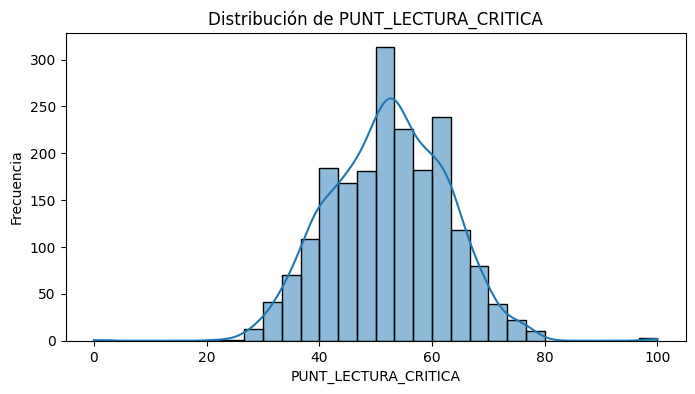

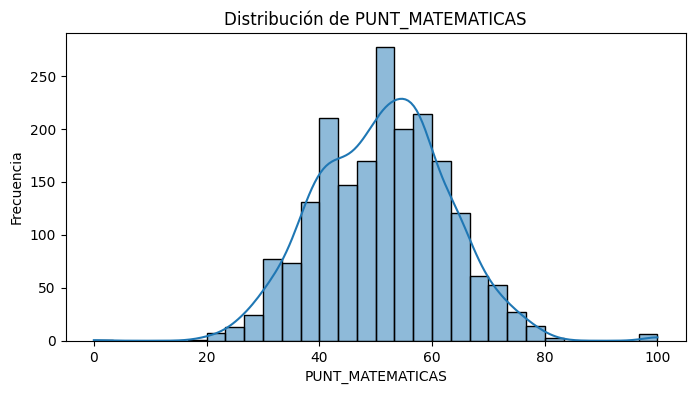

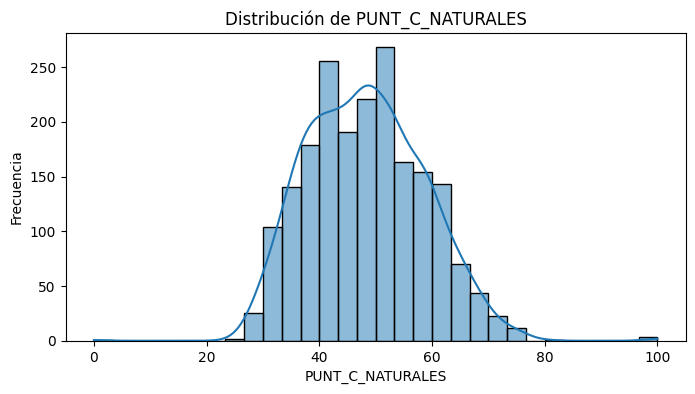

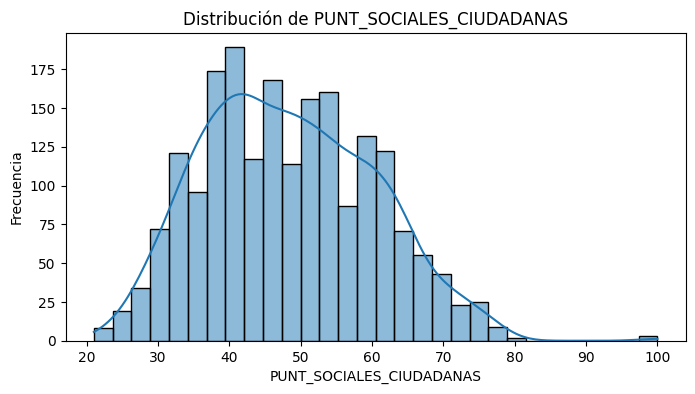

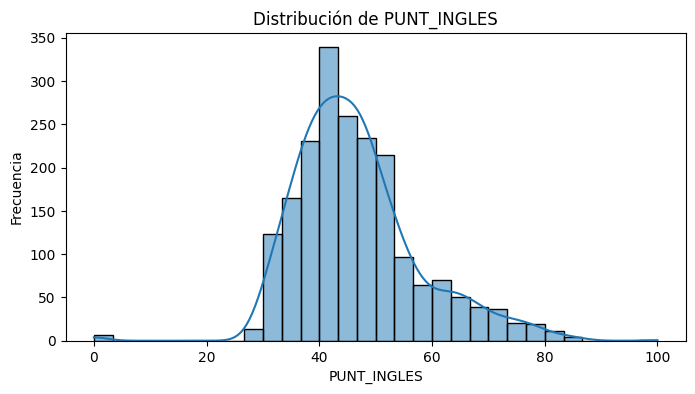

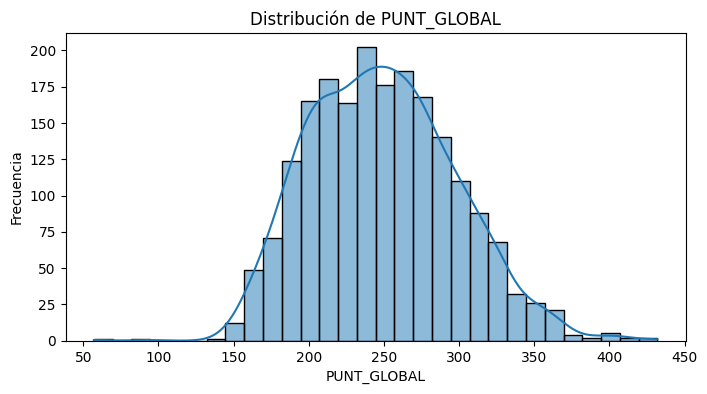

In [26]:
columnas_puntajes = [
    'PUNT_LECTURA_CRITICA',
    'PUNT_MATEMATICAS',
    'PUNT_C_NATURALES',
    'PUNT_SOCIALES_CIUDADANAS',
    'PUNT_INGLES',
    'PUNT_GLOBAL'
]

for columna in columnas_puntajes:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[columna], kde=True, bins=30)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.show()


4.1 Aplicaremos test de normalidad para erificar si son distribuciones normales

4.1 Gráficos QQ

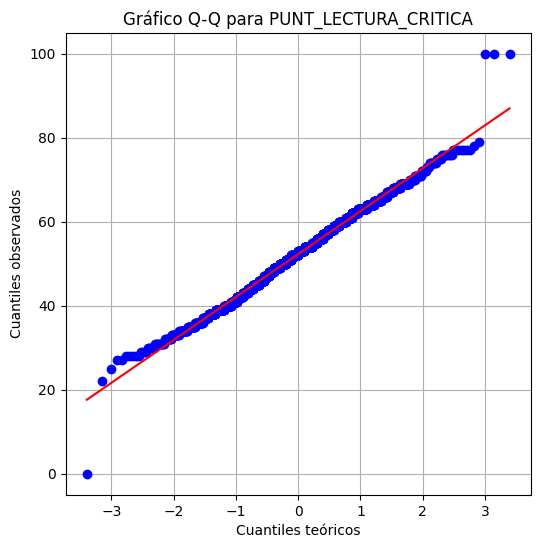

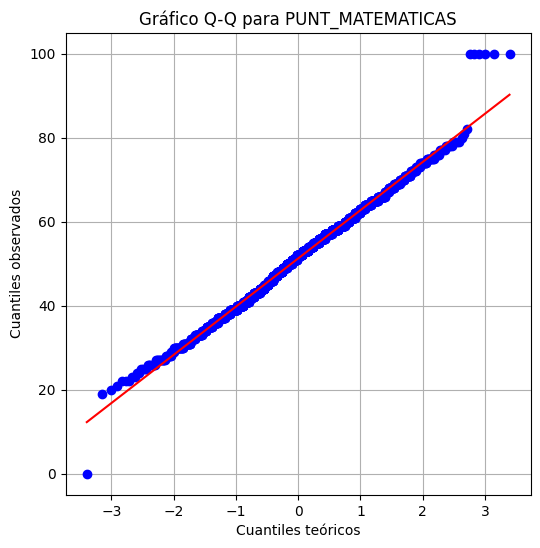

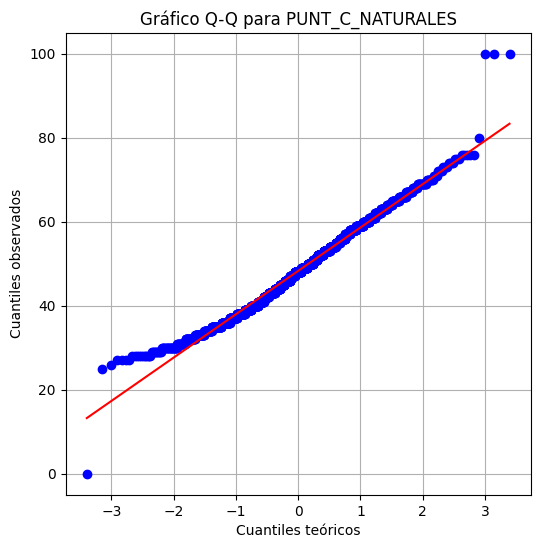

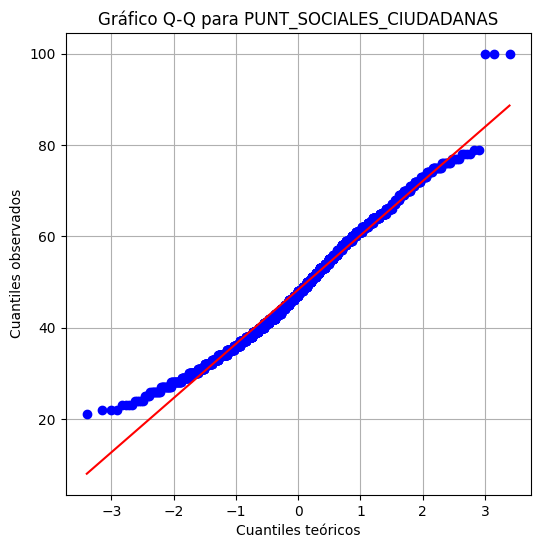

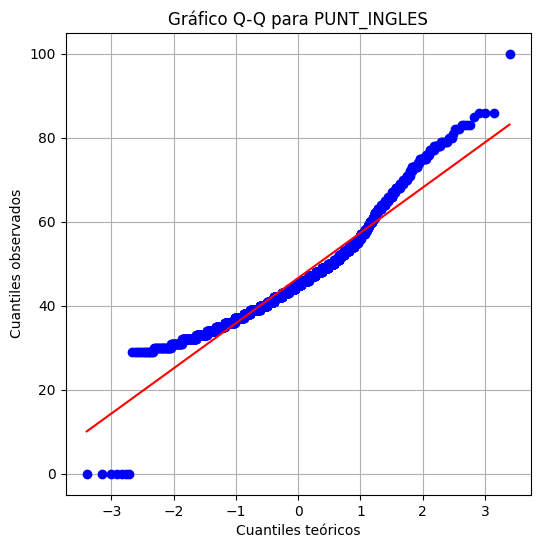

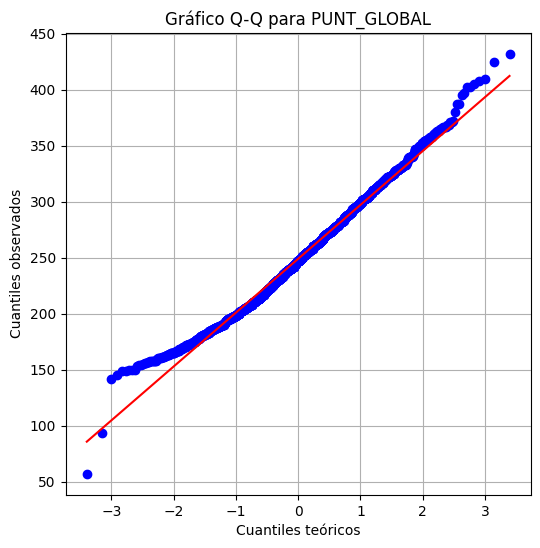

In [27]:
def graficar_qq(datos, nombre):
    plt.figure(figsize=(6, 6))
    stats.probplot(datos, dist="norm", plot=plt)
    plt.title(f"Gráfico Q-Q para {nombre}")
    plt.xlabel("Cuantiles teóricos")
    plt.ylabel("Cuantiles observados")
    plt.grid(True)
    plt.show()

for col in columnas_puntajes:
    if col in df.columns:
        graficar_qq(df[col].dropna(), col)
    else:
        print(f"La columna {col} no está en el DataFrame.")



4.1 Matriz de correlación entre puntajes

Alguna variable NO es normal. Se usará correlación de Spearman.


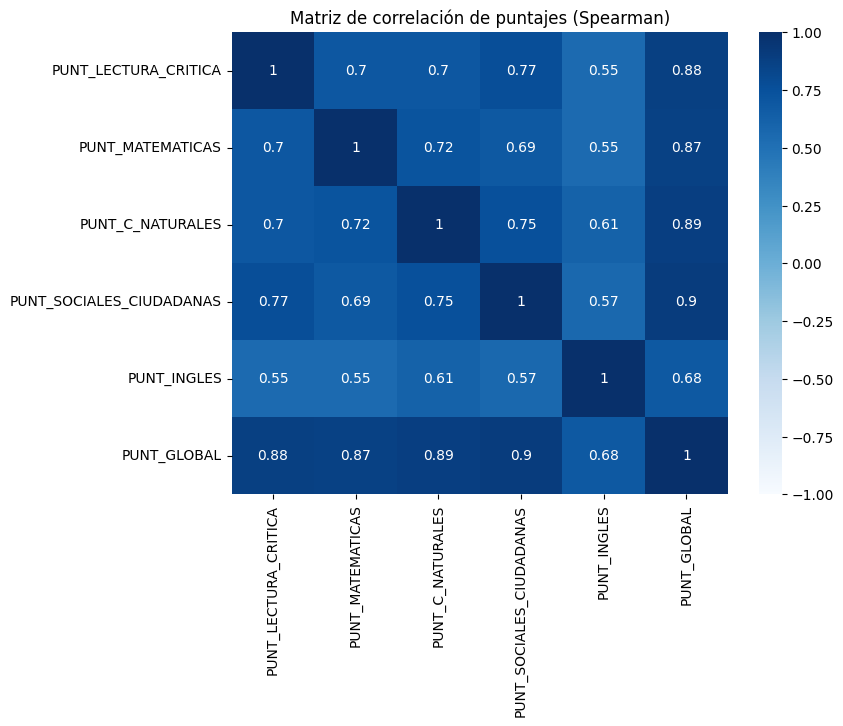

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson, jarque_bera

# Lista de variables de puntaje
columnas_puntajes = [
    'PUNT_LECTURA_CRITICA',
    'PUNT_MATEMATICAS',
    'PUNT_C_NATURALES',
    'PUNT_SOCIALES_CIUDADANAS',
    'PUNT_INGLES',
    'PUNT_GLOBAL'
]

# Función para verificar normalidad (al menos 3 tests deben indicar normalidad)
def es_normal(datos):
    datos = datos.dropna()
    # Shapiro-Wilk
    _, p_sw = shapiro(datos)
    # Kolmogorov-Smirnov
    media, desv = np.mean(datos), np.std(datos)
    _, p_ks = kstest(datos, "norm", args=(media, desv))
    # Anderson-Darling
    resultado_ad = anderson(datos)
    ad_normal = resultado_ad.statistic < resultado_ad.critical_values[2]  # 5%
    # Jarque-Bera
    _, p_jb = jarque_bera(datos)
    normales = [
        p_sw > 0.05,
        p_ks > 0.05,
        ad_normal,
        p_jb > 0.05
    ]
    return normales.count(True) >= 3

# Verificar normalidad de cada variable
normalidad = {}
for col in columnas_puntajes:
    if col in df.columns:
        normalidad[col] = es_normal(df[col])
    else:
        normalidad[col] = False

# Seleccionar el método de correlación adecuado
if all(normalidad.values()):
    metodo_corr = 'pearson'
    print("Todas las variables son normales. Se usará correlación de Pearson.")
else:
    metodo_corr = 'spearman'
    print("Alguna variable NO es normal. Se usará correlación de Spearman.")

# Calcular la matriz de correlación
matriz_corr = df[columnas_puntajes].corr(method=metodo_corr)

# Graficar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title(f'Matriz de correlación de puntajes ({metodo_corr.capitalize()})')
plt.show()




In [29]:
# Se buscan datos atípicos y se eliminan usando la técnica de rango intercuartílico

# Calcular Q1, Q3 e IQR para las columnas de puntaje
Q1 = df[columnas_puntajes].quantile(0.25)
Q3 = df[columnas_puntajes].quantile(0.75)
IQR = Q3 - Q1

# Diccionario para almacenar la cantidad de valores atípicos eliminados por columna
outliers_removed = {}

# Crear una copia del DataFrame para el filtrado
filtered_df = df.copy()

for col in columnas_puntajes:
    initial_count = filtered_df.shape[0]
    # Filtrar valores atípicos según IQR para la columna actual
    mask = (filtered_df[col] >= (Q1[col] - 1.5 * IQR[col])) & (filtered_df[col] <= (Q3[col] + 1.5 * IQR[col]))
    filtered_df = filtered_df[mask]
    final_count = filtered_df.shape[0]
    outliers_removed[col] = initial_count - final_count

# Imprimir la cantidad de valores atípicos eliminados por columna
for col, count in outliers_removed.items():
    print(f"Columna '{col}': {count} valores atípicos eliminados")

# Imprimir cuántos valores quedan después del filtrado
print(f"\nEl DataFrame filtrado tiene {filtered_df.shape[0]} filas después de eliminar los outliers.")

# Si quieres seguir trabajando con el DataFrame filtrado:
df_puntajes_filtrado = filtered_df.copy()


Columna 'PUNT_LECTURA_CRITICA': 5 valores atípicos eliminados
Columna 'PUNT_MATEMATICAS': 5 valores atípicos eliminados
Columna 'PUNT_C_NATURALES': 2 valores atípicos eliminados
Columna 'PUNT_SOCIALES_CIUDADANAS': 3 valores atípicos eliminados
Columna 'PUNT_INGLES': 71 valores atípicos eliminados
Columna 'PUNT_GLOBAL': 0 valores atípicos eliminados

El DataFrame filtrado tiene 1914 filas después de eliminar los outliers.


Se ejecutan de nuevo test de normalidad para verificar si después de eliminar outliers son variables que siguen la distribución normal 

Alguna variable NO es normal. Se usará correlación de Spearman.


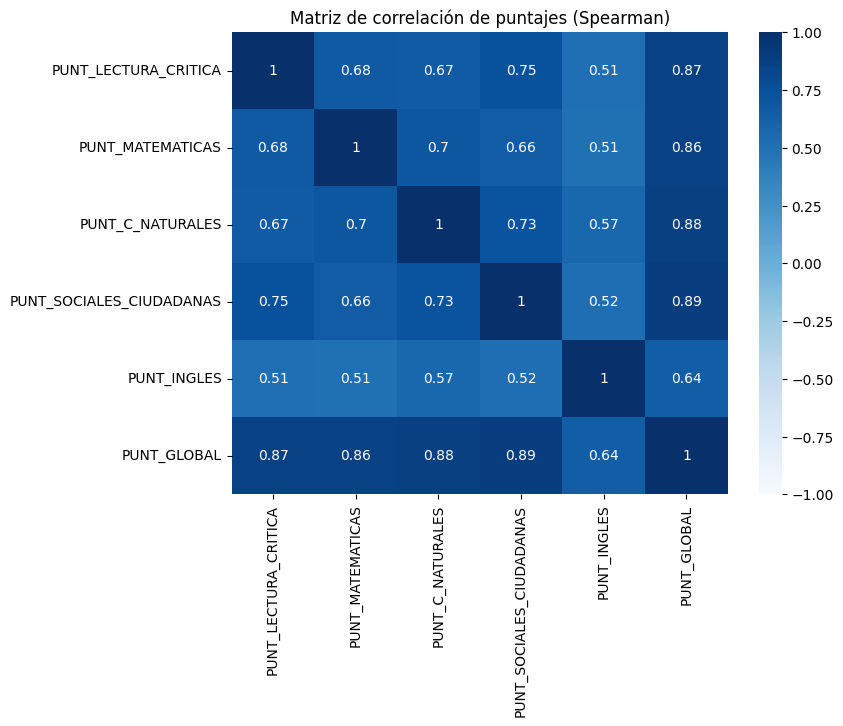

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson, jarque_bera

# Lista de variables de puntaje
columnas_puntajes = [
    'PUNT_LECTURA_CRITICA',
    'PUNT_MATEMATICAS',
    'PUNT_C_NATURALES',
    'PUNT_SOCIALES_CIUDADANAS',
    'PUNT_INGLES',
    'PUNT_GLOBAL'
]

# Función para verificar normalidad (al menos 3 tests deben indicar normalidad)
def es_normal(datos):
    datos = datos.dropna()
    # Shapiro-Wilk
    _, p_sw = shapiro(datos)
    # Kolmogorov-Smirnov
    media, desv = np.mean(datos), np.std(datos)
    _, p_ks = kstest(datos, "norm", args=(media, desv))
    # Anderson-Darling
    resultado_ad = anderson(datos)
    ad_normal = resultado_ad.statistic < resultado_ad.critical_values[2]  # 5%
    # Jarque-Bera
    _, p_jb = jarque_bera(datos)
    normales = [
        p_sw > 0.05,
        p_ks > 0.05,
        ad_normal,
        p_jb > 0.05
    ]
    return normales.count(True) >= 3

# Verificar normalidad de cada variable en df_puntajes_filtrado
normalidad = {}
for col in columnas_puntajes:
    if col in df_puntajes_filtrado.columns:
        normalidad[col] = es_normal(df_puntajes_filtrado[col])
    else:
        normalidad[col] = False

# Seleccionar el método de correlación adecuado
if all(normalidad.values()):
    metodo_corr = 'pearson'
    print("Todas las variables son normales. Se usará correlación de Pearson.")
else:
    metodo_corr = 'spearman'
    print("Alguna variable NO es normal. Se usará correlación de Spearman.")

# Calcular la matriz de correlación
matriz_corr = df_puntajes_filtrado[columnas_puntajes].corr(method=metodo_corr)

# Graficar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title(f'Matriz de correlación de puntajes ({metodo_corr.capitalize()})')
plt.show()


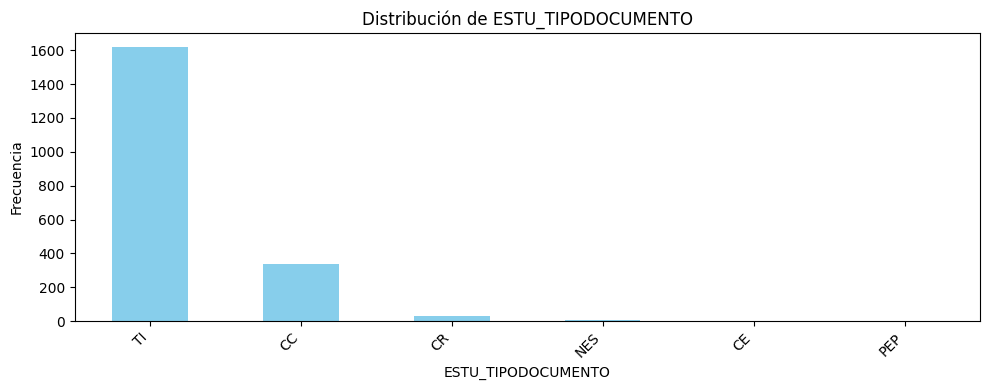

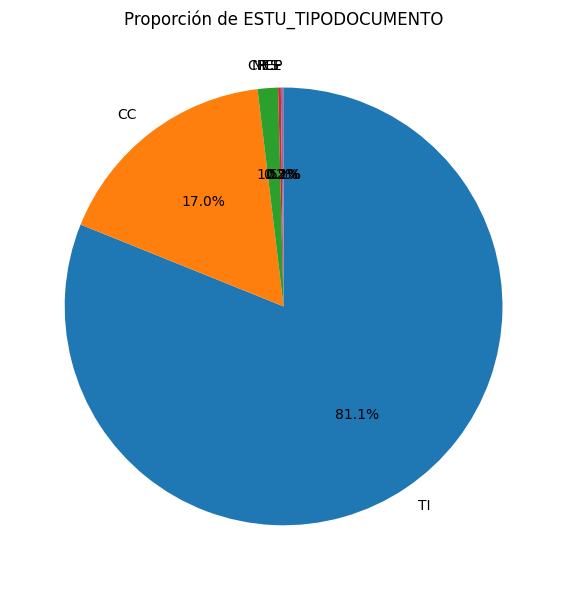

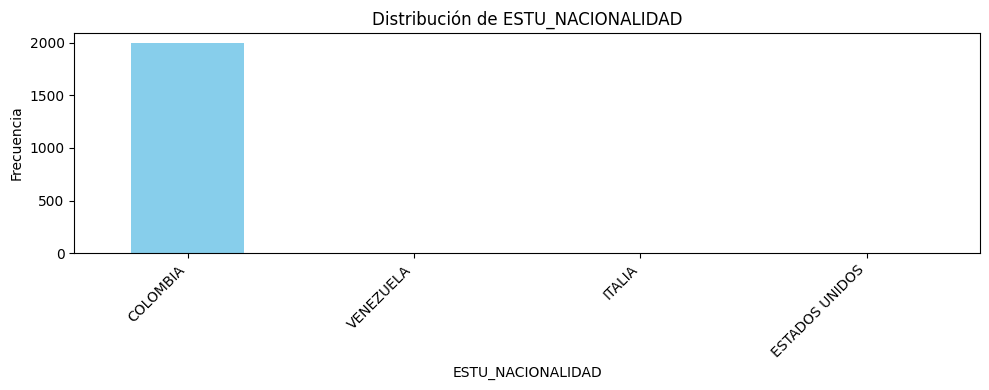

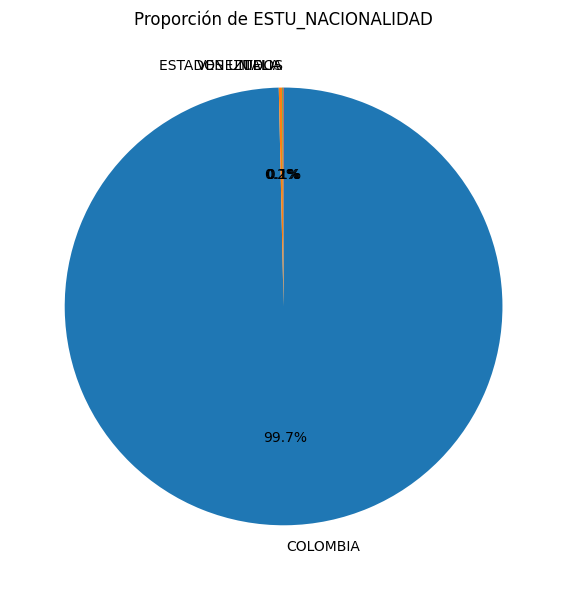

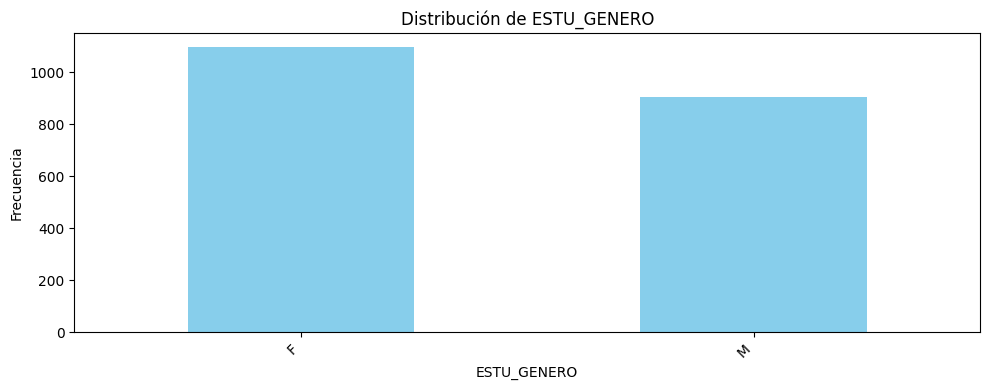

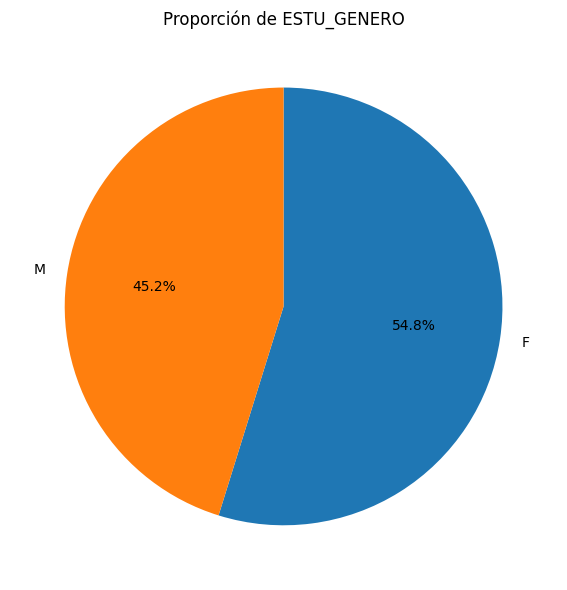

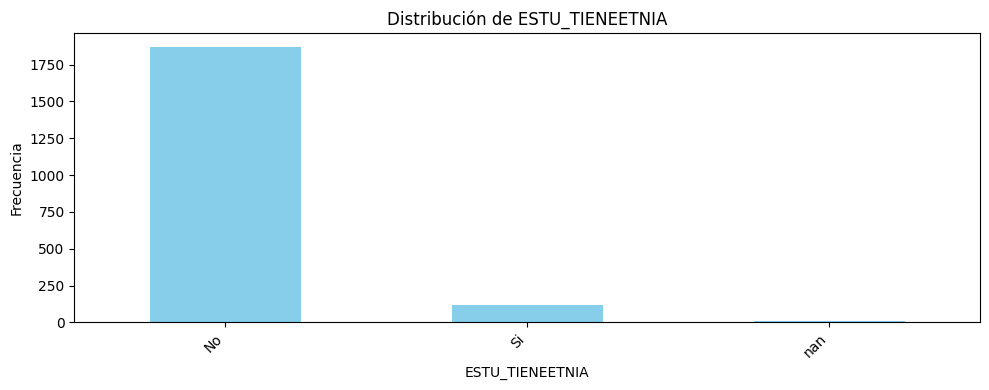

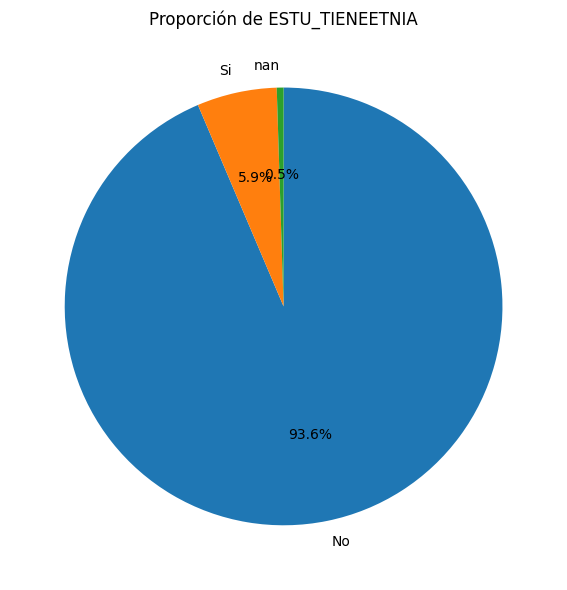

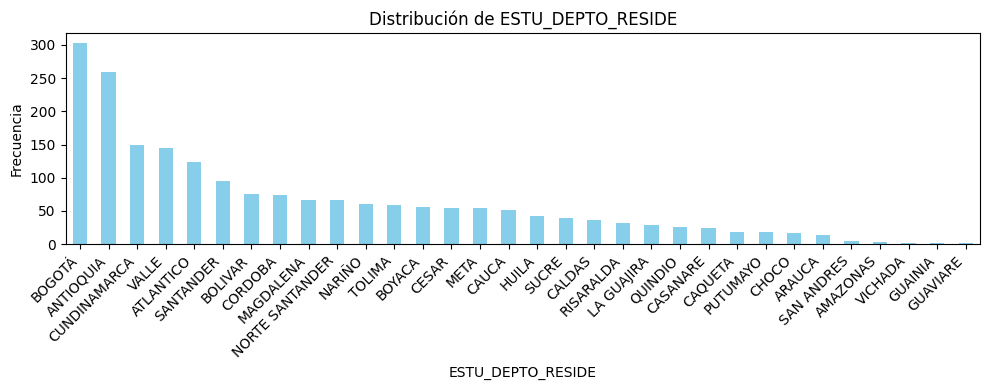

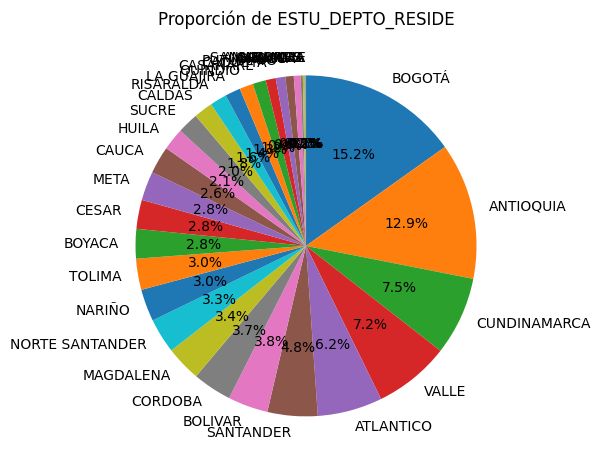

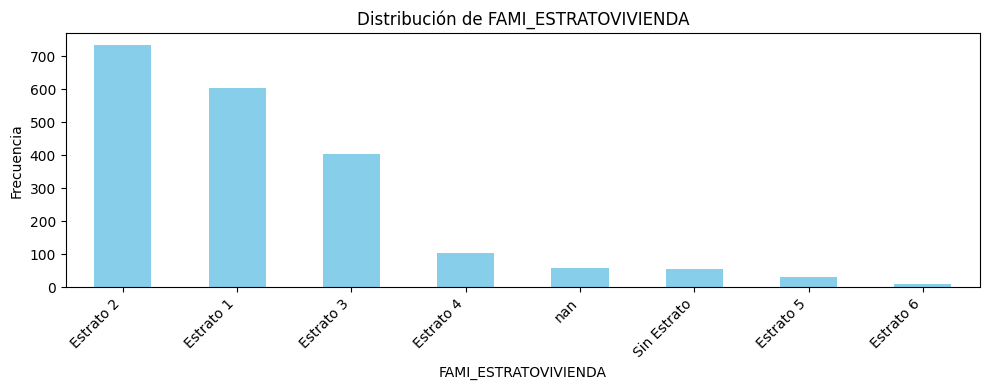

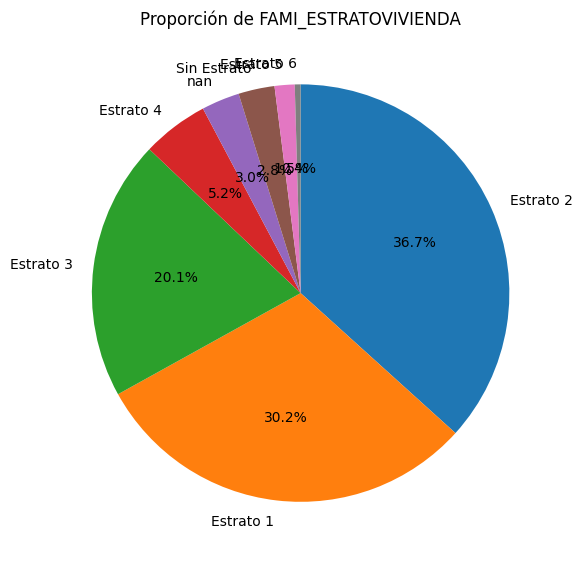

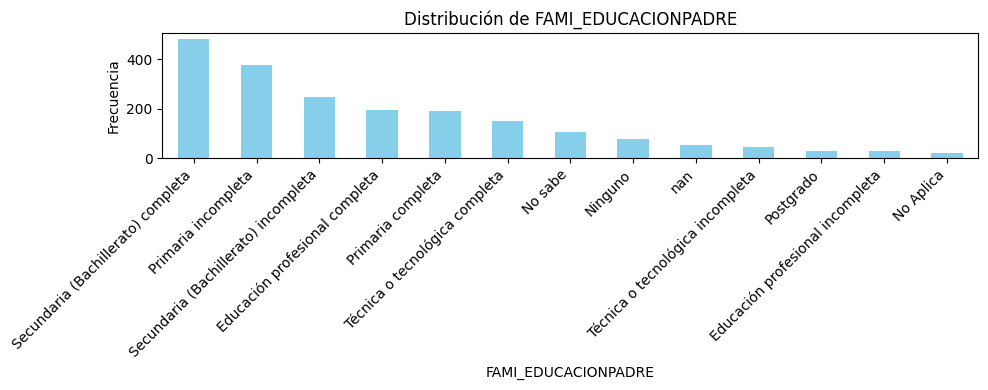

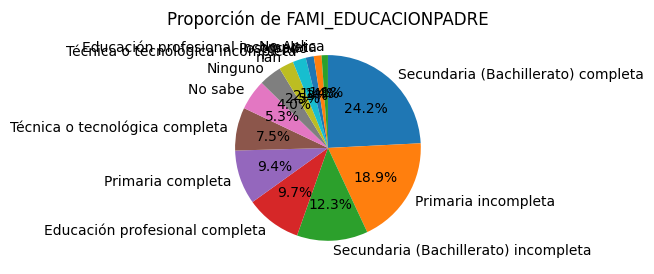

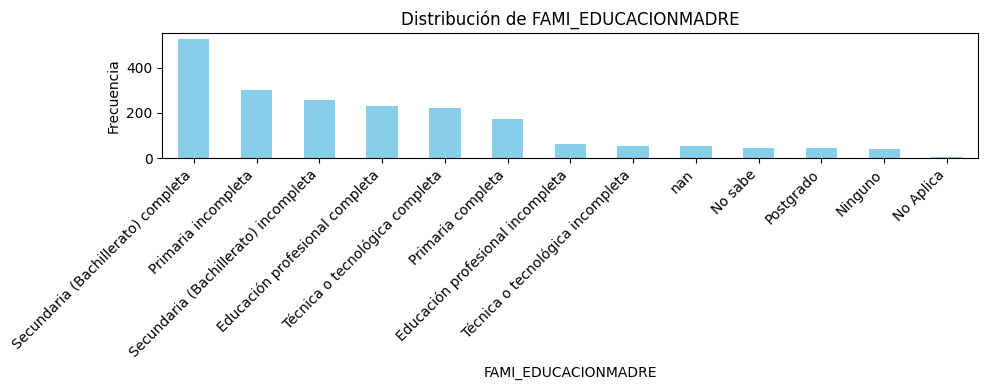

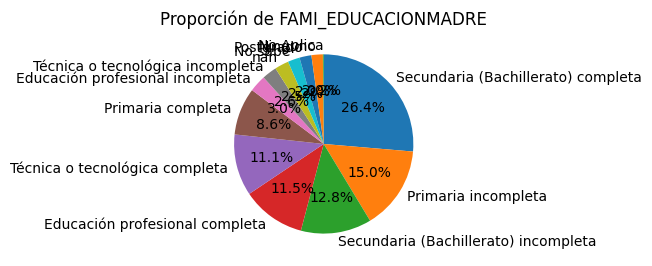

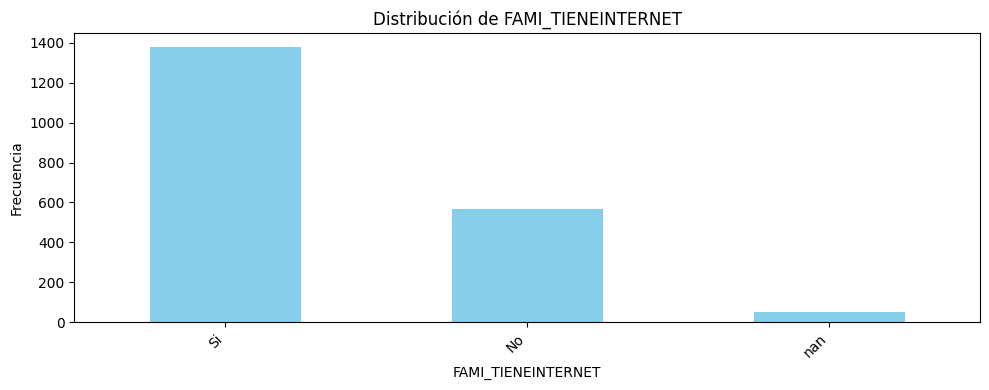

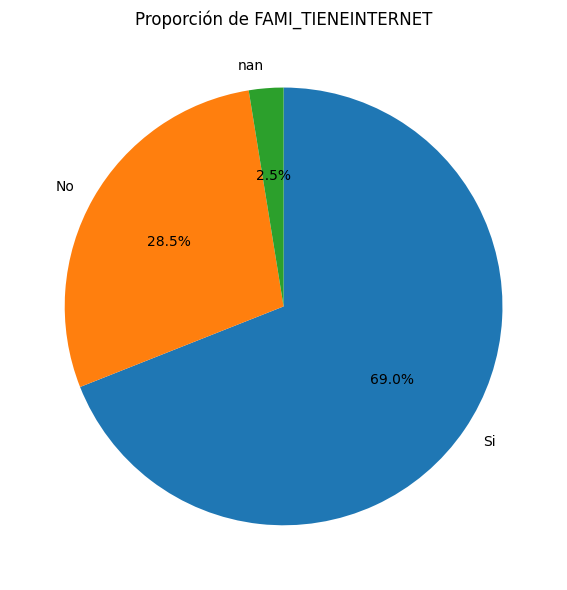

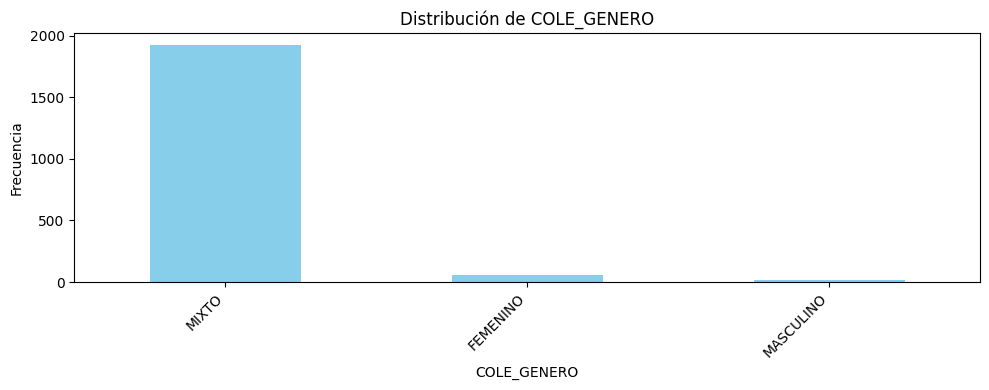

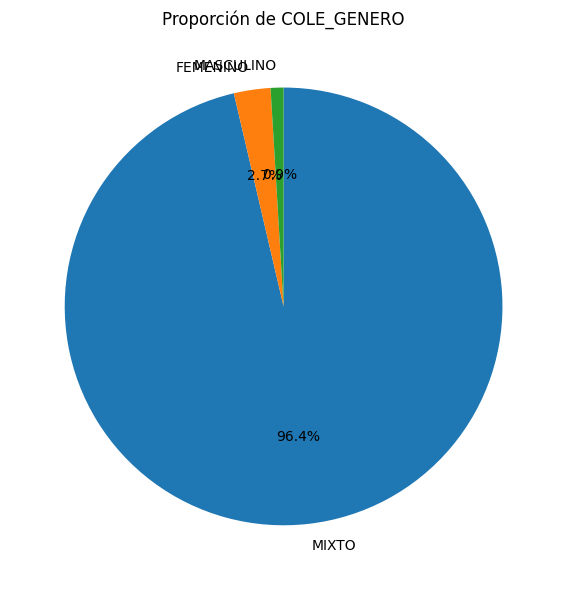

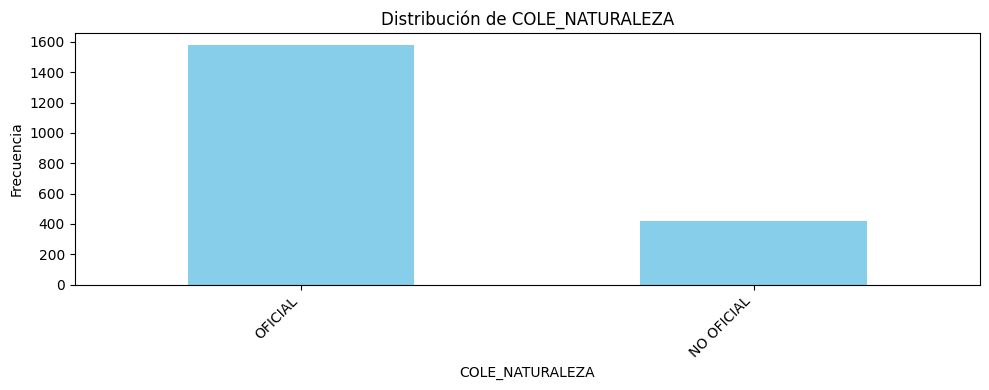

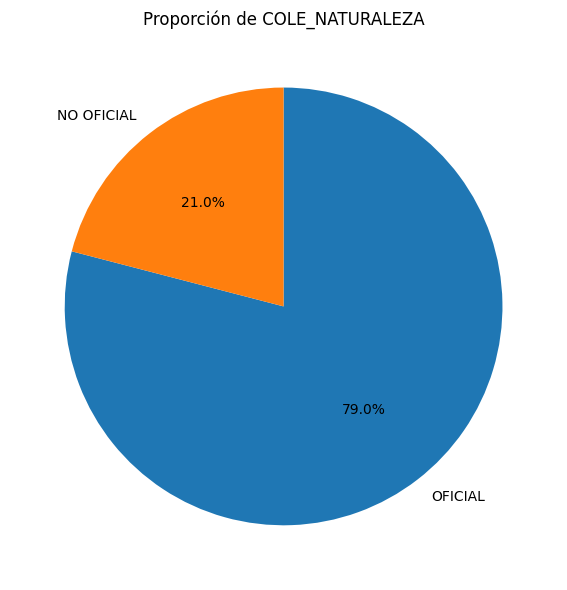

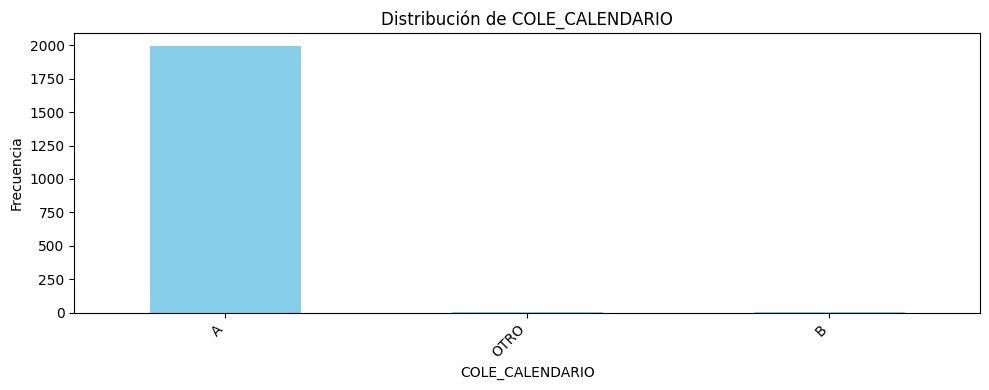

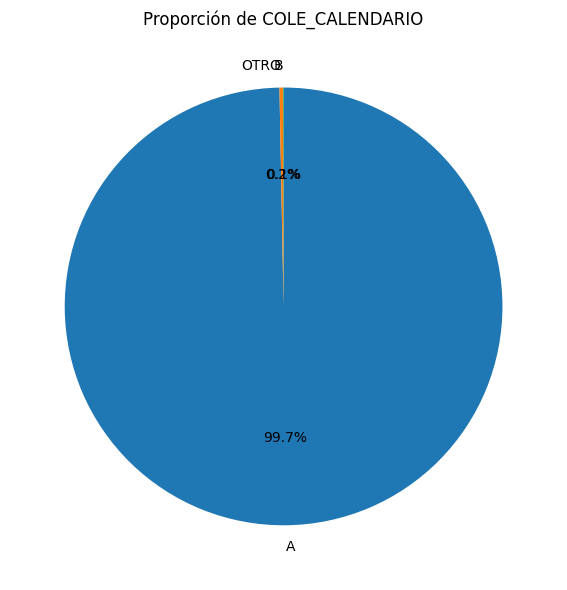

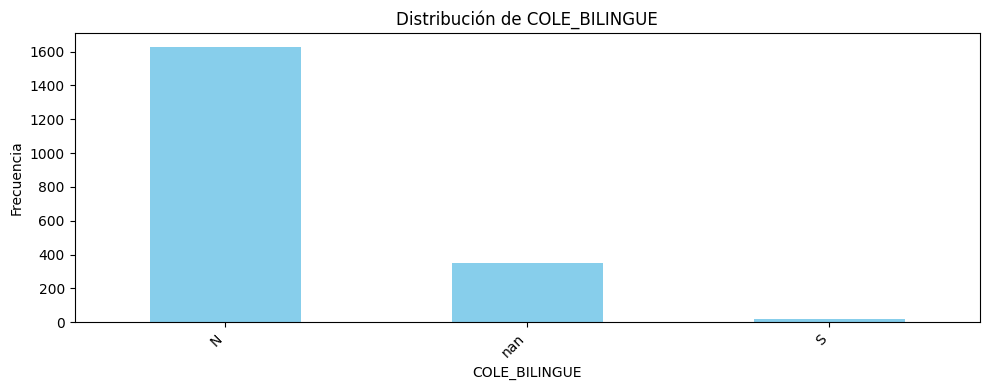

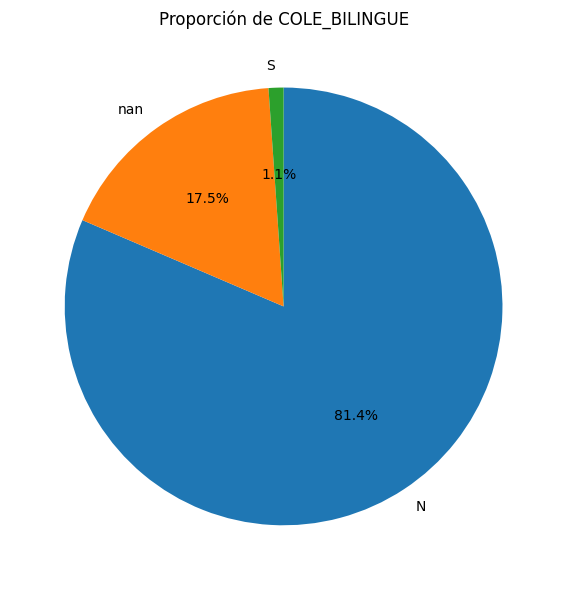

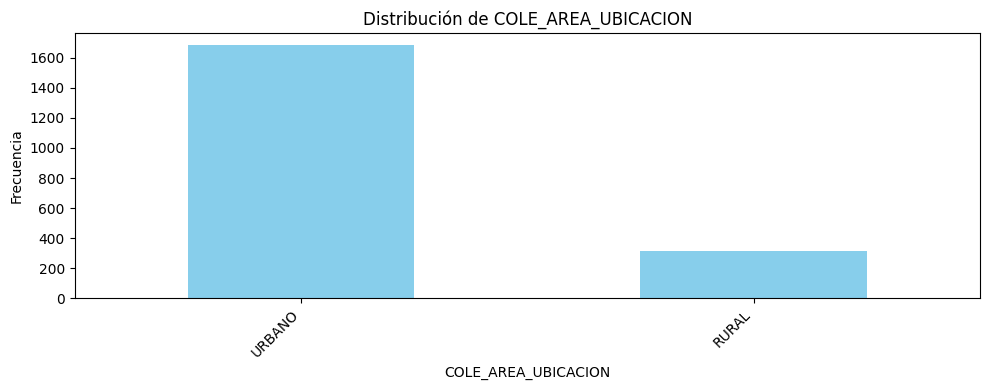

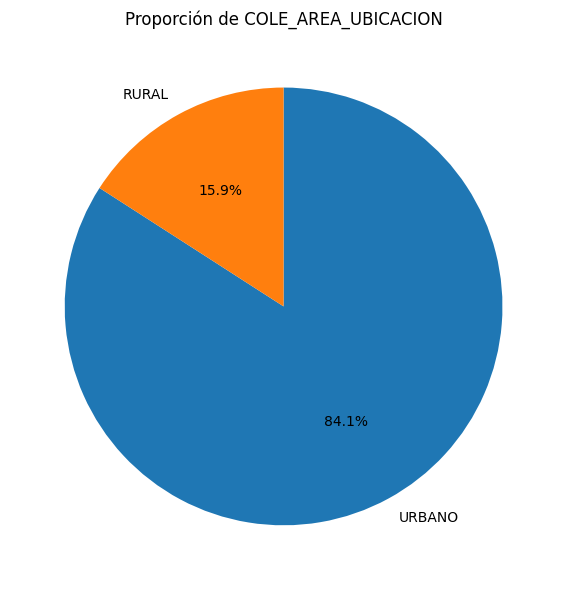

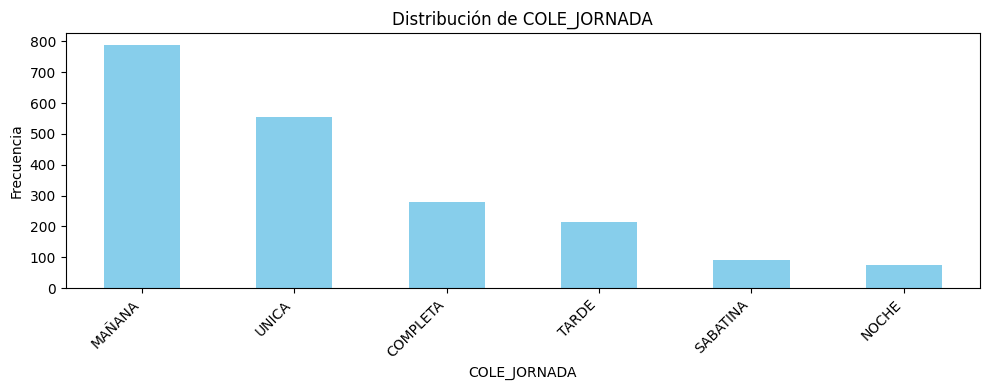

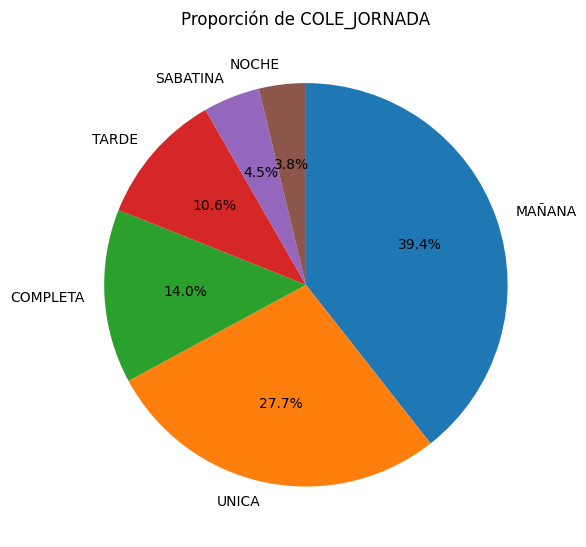

In [31]:
import matplotlib.pyplot as plt

# Lista de variables categóricas a graficar
categorical_vars = [
    'ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO', 'ESTU_TIENEETNIA',
    'ESTU_DEPTO_RESIDE', 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE', 'FAMI_TIENEINTERNET', 'COLE_GENERO', 'COLE_NATURALEZA',
    'COLE_CALENDARIO', 'COLE_BILINGUE', 'COLE_AREA_UBICACION', 'COLE_JORNADA'
]

for col in categorical_vars:
    if col in df.columns:
        # Gráfico de barras
        plt.figure(figsize=(10, 4))
        df[col].value_counts(dropna=False).plot(kind='bar', color='skyblue')
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Gráfico de torta (pastel)
        plt.figure(figsize=(6, 6))
        df[col].value_counts(dropna=False).plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
        plt.title(f'Proporción de {col}')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    else:
        print(f"La columna {col} no está presente en el DataFrame.")
